In [61]:
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt

In [62]:
from scipy.stats import pearsonr
from numpy import corrcoef
import numpy as np

In [63]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [64]:
llvm_ssa = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQiEAyOjaH6pg_kCnExOT2-V2blX0kAGM1oPhVOGepOtmU_wA68oyu-ZX2cUNkX-JDddJUQf_EUb5ji/pub?gid=0&single=true&output=csv')

In [65]:
stores = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQTcwwyDo6wiFfgryeplLtTgSjwuJXAtDxCjKzRFXGh6PuVHGhhWjfr7Gux6y35QK8bnBBTg8Fyli-R/pub?gid=0&single=true&output=csv')
stores = stores.join(llvm_ssa['STORE'])

In [66]:
loads = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQTcwwyDo6wiFfgryeplLtTgSjwuJXAtDxCjKzRFXGh6PuVHGhhWjfr7Gux6y35QK8bnBBTg8Fyli-R/pub?gid=149453782&single=true&output=csv')
loads = loads.join(llvm_ssa['LOAD'])

In [67]:
def proportion(df, name, llvm_name):
    inv = (df[name] - llvm_ssa[llvm_name])/(df[name])
    vi = llvm_ssa[llvm_name]/df[name]
    return (vi, inv)

In [68]:
stores_visible, stores_invisible = proportion(stores, 'stores_total', 'STORE')

In [70]:
loads_visible, loads_invisible = proportion(loads, 'loads_total', 'LOAD')

# Address Sanitizer

In [71]:
asan = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTMGYNoSG5cVK1jzNKUmIn0DDM8bM55qqCjDS06-9Uh-PshcIZjlaLPx9crgkqSfpPxWRHpT_nQZBkJ/pub?output=csv')

# Mem2Reg Time

In [72]:
time = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vStt80Y2PuVW51DrnRU3ub8pdGffmYv8SmRIpugtCwkmbhiGDshI5_VXTZJNK2_JUp4k4_itFQcPYi1/pub?gid=0&single=true&output=csv')
time['suite'] = time.benchmark.apply(lambda x: x.split('/')[1])
# time = time[time.suite == 'cpu2006']
time['NoSSAMean'] = time['NoSSAMean'].apply(float)

In [73]:
llvm_no_ssa = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQiEAyOjaH6pg_kCnExOT2-V2blX0kAGM1oPhVOGepOtmU_wA68oyu-ZX2cUNkX-JDddJUQf_EUb5ji/pub?gid=1365136819&single=true&output=csv')
llvm_no_ssa['suite'] = llvm_no_ssa.Benchmark.apply(lambda x: x.split('/')[1])
# llvm_no_ssa = llvm_no_ssa[llvm_no_ssa.suite == 'cpu2006']

# Comparison time with(out) SSA

In [80]:
time['time_ratio'] = time['SSAMean'] / time['NoSSAMean']
time['speedup'] = time['NoSSAMean'] / time['SSAMean']
# time['store_ratio'] = (llvm_no_ssa['STORE'] - llvm_ssa['STORE']) / llvm_no_ssa['STORE']
time['store_ratio'] = llvm_no_ssa['STORE'] / llvm_ssa['STORE']
time['load_ratio'] = (llvm_no_ssa['LOAD'] - llvm_ssa['LOAD']) / llvm_no_ssa['LOAD']
time['memory_ssa'] = (llvm_ssa['LOAD'] + llvm_ssa['STORE'] )
time['memory_no_ssa'] = (llvm_no_ssa['LOAD'] + llvm_no_ssa['STORE'] )
time['memory_ratio'] = (llvm_no_ssa['STORE'] + llvm_no_ssa['LOAD']) / (llvm_ssa['STORE'] + llvm_ssa['LOAD'])

In [81]:
time = time.query('store_ratio != inf')

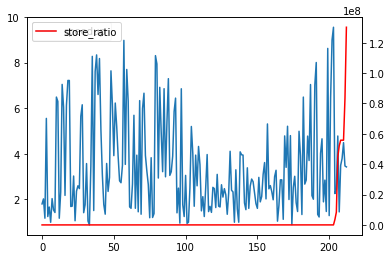

In [82]:
df = time.sort_values(by='store_ratio').reset_index(drop=True)
# ax0 = df.SSAMean.plot(legend=True, color='red')
# df.NoSSAMean.plot(legend=True, color='black', ax=ax0)

ax0 = df.speedup.plot(legend=True)
ax1 = ax0.twinx()
# df.time_ratio.plot(ax=ax1, legend=True)
# df.load_ratio.plot(ax=ax1, legend=True)
df.store_ratio.plot(ax=ax1, legend=True, color='red')


## Is speedup proportional to the ratio of visible instructions of a type T?

In [83]:
pearsonr(df.speedup, df.store_ratio)

(0.00527478521047824, 0.9389970617051179)

In [84]:
pearsonr(df.speedup, df.load_ratio)

(0.113371541777362, 0.09890380139265528)

In [85]:
pearsonr(df.speedup, df.memory_ratio)

(-0.06493423416151063, 0.345628173865254)

# Scatter Plot

In [175]:
time.memory_ratio.describe()
time2 = time[(time.memory_ratio < 100) & (time.SSAMean > 50)]

In [176]:
time2.pipe(len)

9

In [177]:
time2

,benchmark,SSATime1,SSATime2,SSATime3,SSATime4,SSATime5,SSAMean,Time1,Time2,Time3,...,NoSSAMean,Ratio,suite,time_ratio,speedup,store_ratio,load_ratio,memory_ssa,memory_no_ssa,memory_ratio
21,Benchs/cpu2006/429.mcf/rbc,292.189,292.175,291.069,291.078,291.444,291.591,348.916,nan,nan,...,348.916,0.836,cpu2006,0.836,1.197,2.942,0.690,150354555589,476466285812,3.169
22,Benchs/cpu2006/433.milc/rbc,378.282,377.213,377.187,377.198,378.729,377.722,607.381,nan,nan,...,607.381,0.622,cpu2006,0.622,1.608,7.259,0.838,419815819848,2692889984324,6.414
23,Benchs/cpu2006/444.namd/rbc,323.258,322.213,322.199,323.233,322.610,322.703,640.095,nan,nan,...,640.095,0.504,cpu2006,0.504,1.984,10.845,0.840,526417285755,3718728114089,7.064
24,Benchs/cpu2006/445.gobmk/rbc,58.073,58.072,58.065,58.069,58.141,58.084,81.977,nan,nan,...,81.977,0.709,cpu2006,0.709,1.411,3.297,0.637,74511235088,213474264903,2.865
25,Benchs/cpu2006/456.hmmer/rbc,404.753,404.733,403.628,404.718,404.178,404.402,676.437,nan,nan,...,676.437,0.598,cpu2006,0.598,1.673,2.397,0.719,1035335373138,3479687504697,3.361
26,Benchs/cpu2006/458.sjeng/rbc,459.931,457.816,459.876,456.749,457.327,458.340,686.881,nan,nan,...,686.881,0.667,cpu2006,0.667,1.499,4.096,0.633,739725477964,2184716577073,2.953
27,Benchs/cpu2006/462.libquantum/rbc,295.013,295.002,294.955,294.986,295.342,295.060,484.871,nan,nan,...,484.871,0.609,cpu2006,0.609,1.643,4.489,0.668,839709809451,2638397083793,3.142
28,Benchs/cpu2006/464.h264ref/rbc,60.559,61.651,60.552,60.552,60.631,60.789,115.028,nan,nan,...,115.028,0.528,cpu2006,0.528,1.892,7.375,0.598,246786181378,753220616508,3.052
29,Benchs/cpu2006/470.lbm/rbc,197.156,197.148,197.130,197.138,197.388,197.192,231.825,nan,nan,...,231.825,0.851,cpu2006,0.851,1.176,1.446,0.805,333288246280,1433868554124,4.302


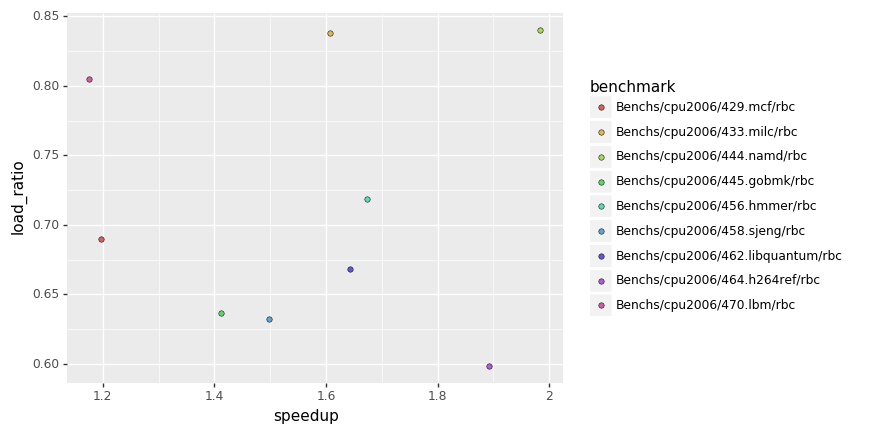

<ggplot: (283835603)>

In [178]:
(ggplot(time2)
+ geom_point(aes(x='speedup', y='load_ratio', fill='benchmark'), stroke=0.2, size=2) 
# + scale_y_log10()
)

In [180]:
pearsonr(time2.speedup, time2.memory_ratio)

(0.3866874627472169, 0.3039200589075749)

In [181]:
pearsonr(time2.speedup, time2.store_ratio)

(0.8170917621965561, 0.007169491484964716)

In [182]:
pearsonr(time2.speedup, time2.load_ratio)

(0.0395453577963359, 0.9195437717259811)

In [94]:
# invisible stores, visible stores, invisible loads, visible loads

# Execution time

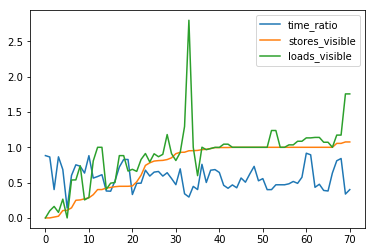

In [16]:
total = loads.loads_total + stores.stores_total
total_visible = loads_visible + stores_visible
total_invisible = loads_invisible + stores_invisible

df = pd.DataFrame(asan['TimeMean']/asan['ASTMean'], columns=['time_ratio'])\
    .join(loads.benchmark.to_frame('benchmark'))\
    .join(loads.loads_main.to_frame('loads_pin'))\
    .join(llvm.LOAD.to_frame('loads_llvm'))\
    .join(stores.stores_main.to_frame('stores_pin'))\
    .join(llvm.STORE.to_frame('stores_llvm'))\
    .join(asan.ASTMean.to_frame('time_asan'))\
    .join(asan.TimeMean.to_frame('time_normal'))

df['loads_visible'] = df.loads_llvm/df.loads_pin
df['loads_invisible'] = 1 - df.loads_visible
df['stores_visible'] = df.stores_llvm/df.stores_pin
df['stores_invisible'] = 1 - df.stores_visible

df['memory_llvm'] = df.loads_llvm + df.stores_llvm
df['memory_pin'] = df.stores_pin + df.loads_pin
df['memory_visible'] = df.memory_llvm/df.memory_pin
df['memory_invisible'] = 1 - df.memory_visible

df['suite'] = df.benchmark.apply(lambda x: x.split('/')[1])

df = df.sort_values(by='stores_visible').query('time_normal > 2 & time_ratio < 0.95').reset_index(drop=True)

ax = df.time_ratio.plot(legend=True)
# ax.twinx()
df.stores_visible.plot(ax=ax, legend=True)
df.loads_visible.plot(ax=ax, legend=True)

In [13]:
pearsonr(df.time_ratio, df.stores_visible)

(-0.24569198885201202, 0.03889812211813017)

In [70]:
pearsonr(df.time_ratio, df.loads_visible)

(-0.269639906835676, 0.022966365950826337)

In [71]:
pearsonr(df.time_ratio, df.memory_visible)

(-0.2517366461237174, 0.034195904083922646)

In [29]:
arr=['Benchs/SciMark2-C',
'Benchs/Ptrdist/anagram','Benchs/Ptrdist/bc','Benchs/Ptrdist/yacr2','Benchs/Ptrdist/ks',
'Benchs/Ptrdist/ft','Benchs/VersaBench/dbms','Benchs/VersaBench/8b10b','Benchs/VersaBench/beamformer',
'Benchs/CoyoteBench/lpbench','Benchs/CoyoteBench/huffbench','Benchs/NPB-serial/dc','Benchs/cpu2006/401.bzip2/src',
'Benchs/cpu2006/429.mcf/src','Benchs/ASC_Sequoia/IRSmk','Benchs/ASC_Sequoia/AMGmk','Benchs/DOE_ProxyApps_C/XSBench',
'Benchs/DOE_ProxyApps_C/SimpleMOC','Benchs/DOE_ProxyApps_C/Pathfinder','Benchs/DOE_ProxyApps_C/miniAMR','Benchs/DOE_ProxyApps_C/RSBench',
'Benchs/DOE_ProxyApps_C/miniGMG','Benchs/McCat/05-eks','Benchs/McCat/01-qbsort','Benchs/McCat/08-main',
'Benchs/McCat/09-vor','Benchs/McCat/03-testtrie','Benchs/McCat/12-IOtest','Benchs/McCat/04-bisect',
'Benchs/McCat/17-bintr','Benchs/Olden/bisort','Benchs/Olden/mst','Benchs/Olden/treeadd',
'Benchs/Olden/em3d','Benchs/Olden/power','Benchs/Olden/health','Benchs/Olden/bh',
'Benchs/Olden/voronoi','Benchs/Olden/tsp','Benchs/Olden/perimeter','Benchs/Stanford/Treesort',
'Benchs/Misc/richards_benchmark','Benchs/Misc/himenobmtxpa','Benchs/Misc/oourafft','Benchs/Misc/lowercase',
'Benchs/Misc/ffbench','Benchs/FreeBench/neural','Benchs/FreeBench/pcompress2','Benchs/FreeBench/analyzer',
'Benchs/FreeBench/pifft','Benchs/sim','Benchs/MallocBench/make','Benchs/MallocBench/cfrac',
'Benchs/MallocBench/gs','Benchs/MallocBench/espresso','Benchs/BenchmarkGame/nsieve-bits','Benchs/BenchmarkGame/puzzle',
'Benchs/Dhrystone/fldry','Benchs/Dhrystone/dry','Benchs/nbench','Benchs/llubenchmark',
'Benchs/MiBench/consumer-lame','Benchs/MiBench/telecomm-FFT','Benchs/MiBench/network-patricia','Benchs/MiBench/consumer-jpeg',
'Benchs/MiBench/automotive-bitcount','Benchs/MiBench/network-dijkstra','Benchs/MiBench/automotive-susan','Benchs/mafft',
'Benchs/Prolangs-C/cdecl','Benchs/Prolangs-C/archie-client','Benchs/Prolangs-C/bison','Benchs/Prolangs-C/assembler',
'Benchs/Prolangs-C/plot2fig','Benchs/Prolangs-C/loader','Benchs/Prolangs-C/simulator','Benchs/Prolangs-C/agrep',
'Benchs/Prolangs-C/unix-smail','Benchs/Prolangs-C/TimberWolfMC','Benchs/ASCI_Purple','Benchs/mediabench/mpeg2/mpeg2dec',
'Benchs/mediabench/jpeg/jpeg-6a','Benchs/mediabench/gsm/toast','Benchs/Trimaran/netbench-url','Benchs/Trimaran/netbench-crc',
'Benchs/McGill/chomp','Benchs/McGill/misr','Benchs/BitBench/drop3','Benchs/BitBench/five11',
'Benchs/BitBench/uuencode','Benchs/BitBench/uudecode','Benchs/Shootout/heapsort','Benchs/Shootout/methcall',
'Benchs/Shootout/lists','Benchs/Shootout/hash','Benchs/Shootout/matrix','Benchs/Shootout/objinst',]

In [48]:
df2 = df[df.benchmark.isin(arr)].sort_values(by='stores_visible').reset_index(drop=True)

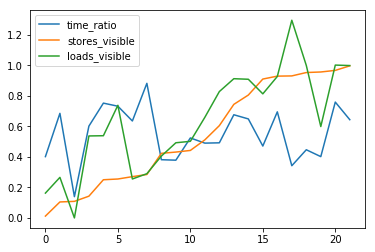

In [49]:
ax = df2.time_ratio.plot(legend=True)
df2.stores_visible.plot(ax=ax, legend=True)
df2.loads_visible.plot(ax=ax, legend=True)

In [46]:
pearsonr(df2.time_ratio, df2.stores_visible)

(0.017193658153563225, 0.9394642589891457)

In [47]:
pearsonr(df2.time_ratio, df2.loads_visible)

(0.17466968901387006, 0.43688970259619375)

# CPU2006

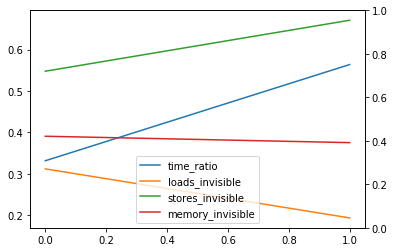

In [26]:
cpu = df[df.suite == 'cpu2006'].sort_values('time_ratio').reset_index(drop=True)
ax = cpu.time_ratio.plot(legend=True)
ax.twinx()
cpu.loads_invisible.plot(ax=ax, legend=True)
cpu.stores_invisible.plot(ax=ax, legend=True)
cpu.memory_invisible.plot(ax=ax, legend=True)

In [28]:
cpu

,time_ratio,benchmark,loads_pin,loads_llvm,stores_pin,stores_llvm,time_asan,time_normal,loads_visible,loads_invisible,stores_visible,stores_invisible,memory_llvm,memory_pin,memory_visible,memory_invisible,suite
0,0.331,Benchs/cpu2006/400.perlbench/rbc,123401628,84929771,61907100,27991105,176.579,58.515,0.688,0.312,0.452,0.548,112920876,185308728,0.609,0.391,cpu2006
1,0.564,Benchs/cpu2006/403.gcc/rbc,35175131049,28379333105,21640956548,7118654179,41.956,23.661,0.807,0.193,0.329,0.671,35497987284,56816087597,0.625,0.375,cpu2006
